# Research and Data Analysis - Red Wine Data

We use the file ‘red_wine_data.csv’. \
This dataset is related to red variant of the Portuguese "Vinho Verde" wine. \
Only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no
data about grape types, wine brand, wine selling price, etc.). \
The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones).

Input variables (based on physicochemical tests):\
1 - fixed acidity\
2 - volatile acidity\
3 - citric acid\
4 - residual sugar\
5 - chlorides\
6 - free sulfur dioxide\
7 - total sulfur dioxide\
8 - density\
9 - pH\
10 - sulphates\
11 - alcohol

Output variable (based on sensory data):\
12 - quality (score between 0 and 10)

My task is to analyse the data and present my findings during the interview.\
I may take a descriptive approach and think about potential ways to present the data, or to
apply any statistical technique to the data to answer a research question that I think can
be answered with this data.

[Reference](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377):
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining
from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [31]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
#

## 1. Preprocessing

In [32]:
df=pd.read_csv(r'red_wine_data/red_wine_data.csv')
df

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [33]:
# define variable types
numeric = [
    'fixedAcidity',
    'volatileAcidity',
    'citricAcid',
    'residualSugar',
    'chlorides',
    'freeSulfurDioxide',
    'totalSulfurDioxide',	
    'density',
    'pH',
    'sulphates',
    'alcohol',
           ]
categorical = [
    'quality'
]

In [34]:
# check nans and infs
for col in numeric:
    print(f"{col} nan values: {np.isnan(df[col]).sum()}")
    print(f"{col} inf values: {np.isinf(df[col]).sum()}")
for col in categorical:
    print(f"{col} nan values: {np.isnan(df[col]).sum()}")
    print(f"{col} inf values: {np.isinf(df[col]).sum()}")

fixedAcidity nan values: 0
fixedAcidity inf values: 0
volatileAcidity nan values: 0
volatileAcidity inf values: 0
citricAcid nan values: 0
citricAcid inf values: 0
residualSugar nan values: 0
residualSugar inf values: 0
chlorides nan values: 0
chlorides inf values: 0
freeSulfurDioxide nan values: 0
freeSulfurDioxide inf values: 0
totalSulfurDioxide nan values: 0
totalSulfurDioxide inf values: 0
density nan values: 0
density inf values: 0
pH nan values: 0
pH inf values: 0
sulphates nan values: 0
sulphates inf values: 0
alcohol nan values: 0
alcohol inf values: 0
quality nan values: 0
quality inf values: 0


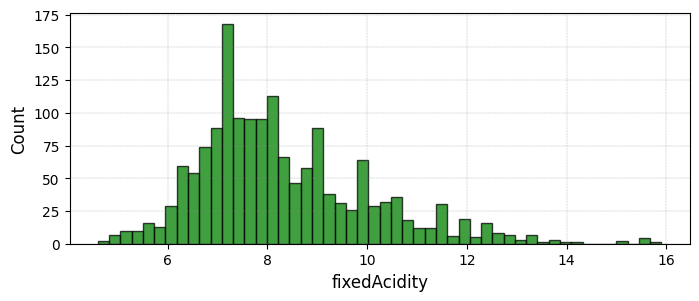

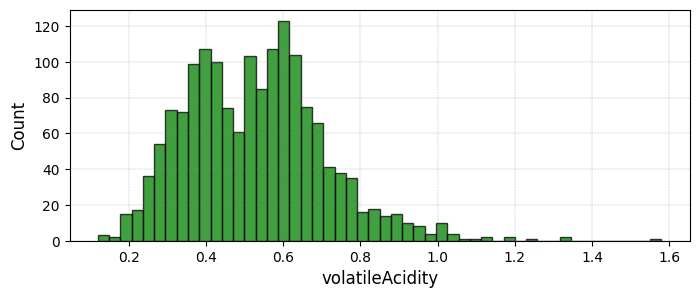

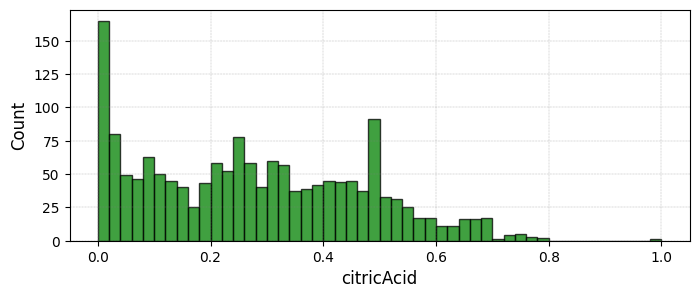

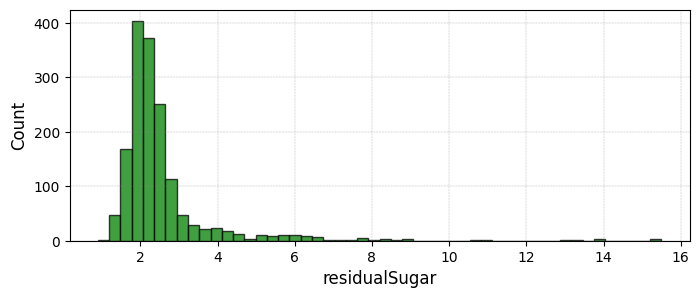

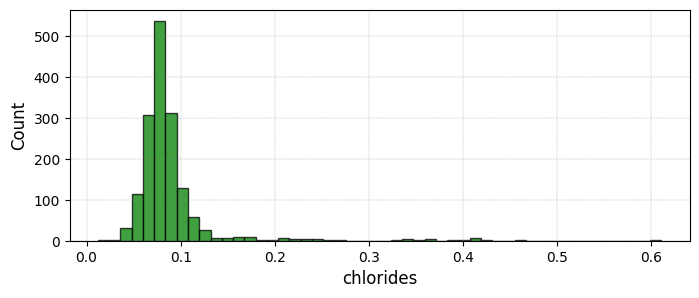

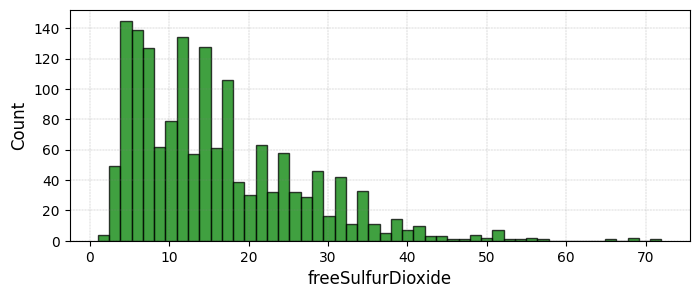

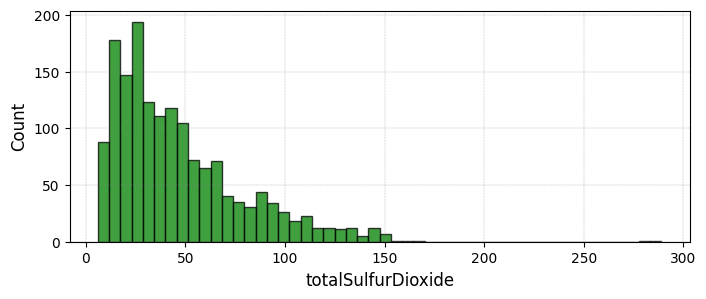

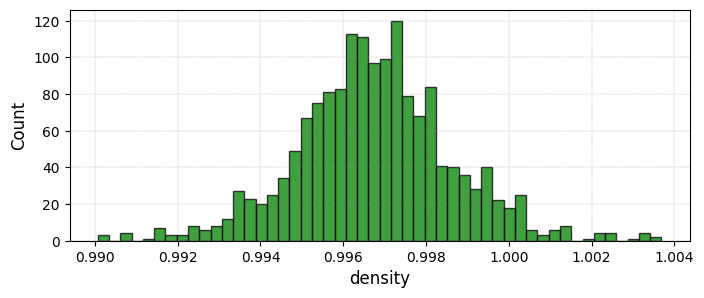

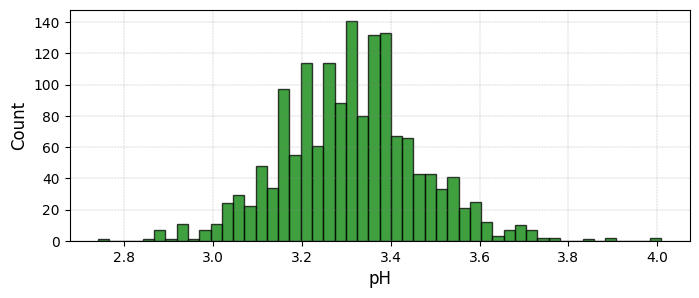

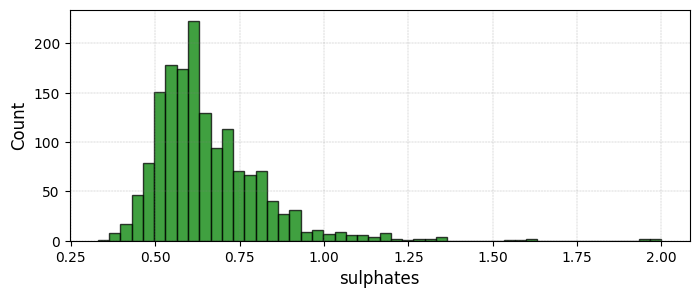

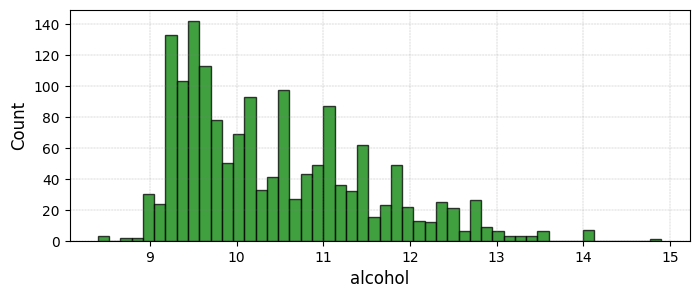

In [35]:
# plot continuous
for var in numeric:
    plt.figure(figsize=(8,3))
    plt.hist(df[var],50,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.ylabel('Count',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.show()

We can see that there are outliers in some of the variables.\
While we don't do anything about it here, we could proceed to treat outliers in the following form:\
1-Winsorizing or Clipping setting a threshold such that outside this threshold values are replaced with the threshold.\
2-Dropping Outliers using statistical methods.\
3-Transforming the data (logarithmic, square root, Box-Cox, ...) to have a more compressed distribution.

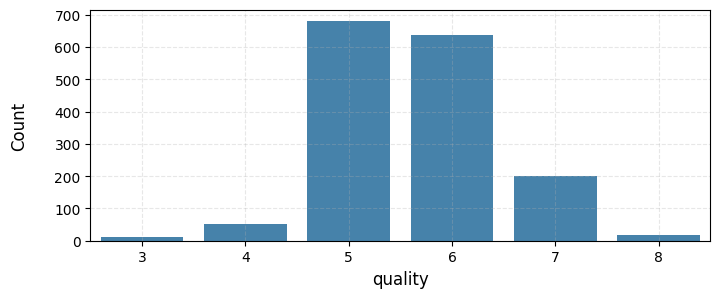

In [36]:
# plot categorical
for var in categorical:
    plt.figure(figsize=(8,3))
    count = df[var].value_counts()
    count.index=count.index.astype(int)
    sns.barplot(count[0:20],alpha=0.9)
    plt.ylabel('Count\n',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.show()

In [37]:
df[var].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

The above graph shows that the classes (quality) are imbalanced.\
There are many techniques to deal with imbalanced data:\
1- Resampling: Undersampling (remove samples from the over-represented classes) or Oversampling (generate new samples from the under-represented class).\
2- Weight classes: adjust class weights in the ML algorithm to address the class imbalance.\
3- Ensemble methods: bagging and boosting methods can improve the model's performance of the minority class.\
4- Use appropriate evaluation metrics: precision, recall, F1-score, or area under the ROC curve (AUC-ROC) which provide a more comprehensive view of model performance on imbalanced datasets.

In [38]:
# Multicollinearity test
# Variance Inflation Factor (VIF)
# VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. 
# A high VIF indicates that a predictor variable is highly collinear with the other predictor variables.
vif_data = df.copy()
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

# Print the VIF values
print(vif)

              Variable          VIF
0         fixedAcidity    74.455312
1      volatileAcidity    17.960867
2           citricAcid     9.192549
3        residualSugar     4.664003
4            chlorides     6.641291
5    freeSulfurDioxide     6.460603
6   totalSulfurDioxide     6.605274
7              density  1528.154302
8                   pH  1078.171089
9            sulphates    22.462103
10             alcohol   147.616345
11             quality    77.728259


The Multicollinearity test shows that some variables in the dataset may be highly correlated, leading to potential issues in a classification analysis, such as overfitting, or model instability.\
The commonly used rule of thumb is that a Variance Inflation Factor (VIF) value above 10 indicates a problematic level of multicollinearity.\
If multicollinearity is detected, it can impact the stability and interpretability of the classification model. 

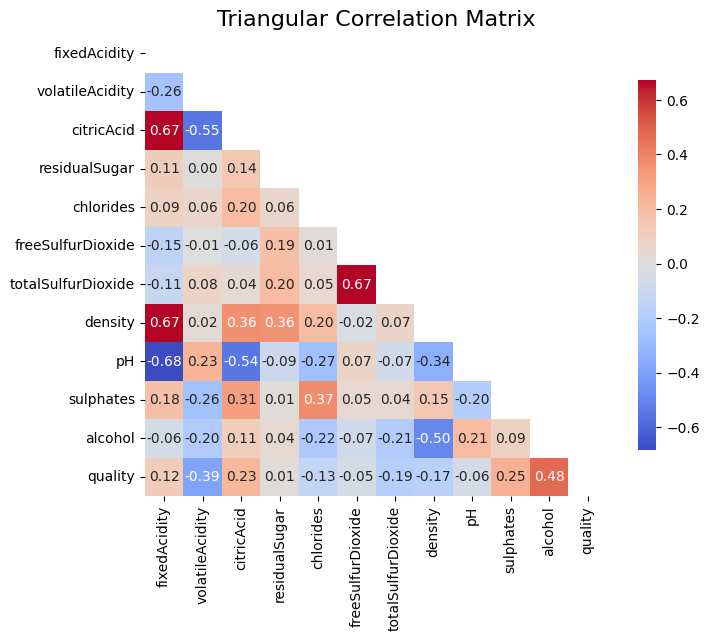

In [39]:
# Assuming df is your DataFrame
correlation_matrix = np.corrcoef(df, rowvar=False)

# Create a mask to hide the upper triangular part and the diagonal
mask = np.triu(np.ones_like(correlation_matrix), k=1)
correlation_matrix[np.eye(correlation_matrix.shape[0], dtype=bool)] = np.nan

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create a seaborn heatmap with the masked upper triangle and no diagonal
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})

# Customize the plot (optional)
plt.title('Triangular Correlation Matrix', fontsize=16)

# Use original column names as tick labels and rotate them
plt.xticks(np.arange(correlation_matrix.shape[0]) + 0.5, labels=df.columns, rotation=90)
plt.yticks(np.arange(correlation_matrix.shape[0]) + 0.5, labels=df.columns, rotation=0)  # You can adjust the rotation angle here

# Adjust the aspect ratio to make the squares square
heatmap.set_aspect('equal')

plt.show()

The pairwise correlation analysis confirms the findings of the multicollinearity test.\
Approaches to address or mitigate multicollinearity:\
1- Remove highly correlated variables: of the highly correlated pairs of variables, keep just one.\
2- Use Principal Component Analysis (PCA) to transform the set of variables into a set of linearly uncorrelated variables (principal components).\
3- Exclude variables with the highest VIF values.\
4- Use L2 regularization (Ridge Regression): Ridge regression penalizes the sum of squared coefficients, distributing the impact of correlated variables more evenly, preventing one variable from dominating the others.

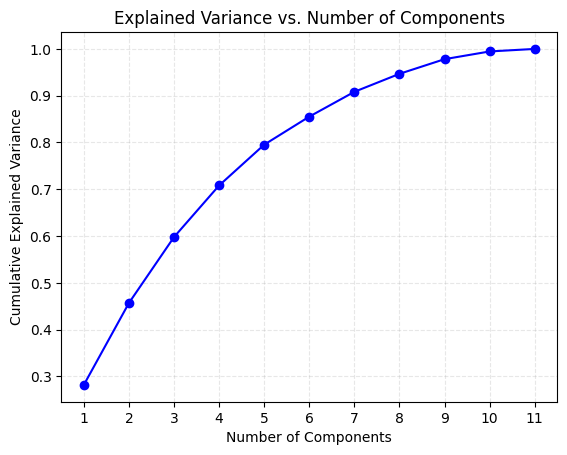

In [51]:
# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df.loc[:, ~df.columns.isin(categorical)])

# Fit PCA
pca = PCA()
pca.fit(df_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot the explained variance and look for an elbow point
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True,alpha=0.3,linestyle='--')
# Set xticks for each component
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.show()

We will select the number of components to retain a variance of 90% of the total variance of the features.\
With this threshold we balance information retention and model complexity.

In [53]:
# Perform PCA with n_components=7
n_components = 7
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_standardized)

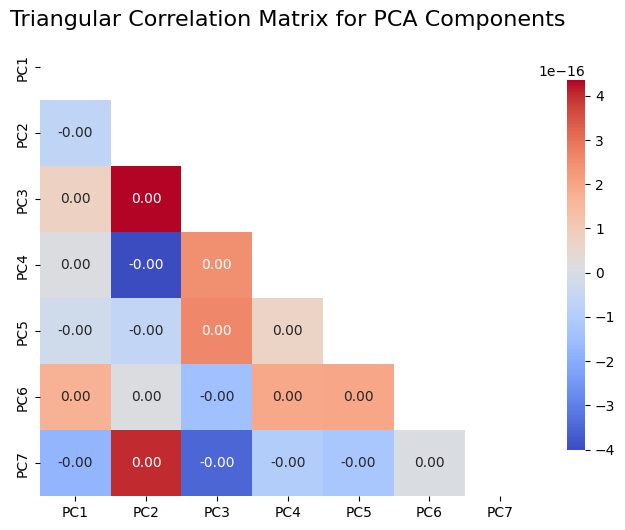

In [57]:
# Calculate the correlation matrix for df_pca
correlation_matrix = np.corrcoef(df_pca, rowvar=False)

# Create a mask to hide the upper triangular part and the diagonal
mask = np.triu(np.ones_like(correlation_matrix), k=1)
correlation_matrix[np.eye(correlation_matrix.shape[0], dtype=bool)] = np.nan

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create a seaborn heatmap with the masked upper triangle and no diagonal
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})

# Customize the plot (optional)
plt.title('Triangular Correlation Matrix for PCA Components', fontsize=16)

# Center the ticks in the middle of the squares
tick_positions = np.arange(0.5, correlation_matrix.shape[0] + 0.5)
plt.xticks(tick_positions, labels=[f'PC{i+1}' for i in range(correlation_matrix.shape[0])])
plt.yticks(tick_positions, labels=[f'PC{i+1}' for i in range(correlation_matrix.shape[0])])

# Show the plot
plt.show()

We can see that the principal components are orthogonal (linearly uncorrelated) to each other.